In [1]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from scipy.stats import kendalltau, pearsonr
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_validate, KFold

import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math as mt
from pylab import savefig
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

from keras import backend as K

# model evaluation
from sklearn.model_selection import KFold, train_test_split 
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [2]:
# LOAD TRAINING DATA FOR TRANSFER LEARNING
df_VALOX_total = pd.read_excel('./data/df_APEC_total.xlsx',index_col=0).fillna(0)
data = df_VALOX_total
train_dataset = data.sample(frac=0.8,random_state=42)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]
test_labels = test_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
test_dataset = test_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

X_train = normed_train_data.fillna(0)
X_test = normed_test_data.fillna(0)
y_train = train_labels
y_test = test_labels

x = np.array(X_train, dtype=np.float)
y = np.array(y_train, dtype=np.float)
x = x.astype(float)
y = y.astype(float)

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
mol_num, feat_num = x.shape
print("Number of materials for training = %i, Number of features = %i\n" % (mol_num, feat_num))

Number of materials for training = 801, Number of features = 50



In [3]:
# create model
def MLP1(feat_num, loss):
    net = Sequential()
    net.add(Dense(50, input_dim=feat_num, kernel_initializer='normal', activation='relu'))
    net.add(Dense(25, kernel_initializer='normal', activation='relu'))
    net.add(Dense(10, kernel_initializer='normal', activation='relu'))
    net.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    net.compile(loss=loss, optimizer='adam')
    return net

In [4]:
# load the dataset 
df_APEC_total=pd.read_excel('./data/df_APEC_total.xlsx',index_col=0)
df_PLEXIGLAS_total=pd.read_excel('./data/df_PLEXIGLAS_total.xlsx',index_col=0)
df_SABIC_total=pd.read_excel('./data/df_SABIC_total.xlsx',index_col=0)
df_ULTEM_total=pd.read_excel('./data/df_ULTEM_total.xlsx',index_col=0)
df_ULTRAMID_total=pd.read_excel('./data/df_ULTRAMID_total.xlsx',index_col=0)
df_VALOX_total=pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0)
df = pd.concat([df_PLEXIGLAS_total, df_SABIC_total, df_ULTEM_total,
                df_ULTRAMID_total, df_VALOX_total])
data = df.fillna(0)
#data = pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0).fillna(0)

train_dataset = data.sample(frac=0.8,random_state=42)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]
test_labels = test_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
test_dataset = test_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

X_train = normed_train_data.fillna(0)
X_test = normed_test_data.fillna(0)
y_train = train_labels
y_test = test_labels

# Make the array shape to x, 1 for multiplication
x_transf = np.array(X_train, dtype=np.float)
y_transf = np.array(y_train, dtype=np.float)
x_transf = x_transf.astype(float)
y_transf = y_transf.astype(float)

mol_num, feat_num = x_transf.shape
print("# molecules for transfer training = %i, # of features = %i\n" % (mol_num, feat_num))

# molecules for transfer training = 2895, # of features = 50



In [5]:
net = MLP1(feat_num=feat_num, 
           loss='mean_absolute_error')
net.fit(x_transf, 
        y_transf,
        epochs=300, 
        batch_size=int(x_transf.shape[0]/8), 
        verbose=0)

### Without transfer

In [6]:
estimator = KerasRegressor(build_fn=MLP1, 
                           feat_num=feat_num, 
                           loss='mean_absolute_error', 
                           epochs=300, 
                           batch_size=int(x.shape[0]/8), 
                           verbose=0)
df_without_transfer= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_without_transfer_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1,11):
    scores = cross_validate(estimator, x[0:int(x.shape[0]*0.1*i),:], y[0:int(y.shape[0]*0.1*i),:], scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['%d percent Fold1'% int(i*10), '%d percent Fold2'% int(i*10), 
                                      '%d percent Fold3'% int(i*10), '%d percent Fold4'% int(i*10),
                                      '%d percent Fold5'% int(i*10)])
    
    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['%d percent'% int(i*10)])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])
    
    df_without_transfer = pd.concat([df_without_transfer, df_scores])
    df_without_transfer_result = pd.concat([df_without_transfer_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  2.012605    0.086193 -0.344229                     -0.687258
10 percent Fold2  1.897531    0.091980 -2.654518                     -1.127284
10 percent Fold3  1.995636    0.083543  0.312609                     -0.725463
10 percent Fold4  1.970380    0.084003 -2.012261                     -0.699516
10 percent Fold5  1.915047    0.111060  0.720502                     -0.327478
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
10 percent -0.795579  1.316531       -0.7134     0.253479
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  2.898539    0.085187  0.861153                     -0.373993
20 percent Fold2  2.662310    0.087476  0.886935                     -0.242974
20 percent Fold3  2.727694    0.086622  0.872767                     -0.237552
20 percent Fold4  2.627660    0.087009  0.924890                     -0.228450
20 percent Fold

### Fine Tuning

In [7]:
def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
    global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
    inp = Input(shape=(feat_num,))
    shared_layer = net.layers[0]
    shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
    out_tensor = shared_layer(inp)
    # idx = 1  # index of desired layer
    for i in range(1,idx+1):
        #print('Transfered layer %d' % i)
        shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
        shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(out_tensor)
    # Here add all the new layers
    for l_size in lhl_sizes[idx:]:
        #print ('Rest layer size %d ' % l_size)
        out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
    # Close the network
    out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
    # Create the model
    transf_model = Model(inp, out_tensor)
    transf_model.compile(loss=loss, optimizer='adam')
    return transf_model

estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=3,
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

In [8]:
df_transfer_fine_tuning= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_transfer_fine_tuning_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1,11):
    scores = cross_validate(estimator, x[0:int(x.shape[0]*0.1*i),:], y[0:int(y.shape[0]*0.1*i),:], scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['%d percent Fold1'% int(i*10), '%d percent Fold2'% int(i*10), 
                                      '%d percent Fold3'% int(i*10), '%d percent Fold4'% int(i*10),
                                      '%d percent Fold5'% int(i*10)])
    
    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['%d percent'% int(i*10)])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])
    
    df_transfer_fine_tuning = pd.concat([df_transfer_fine_tuning, df_scores])
    df_transfer_fine_tuning_result = pd.concat([df_transfer_fine_tuning_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  2.216301    0.106794 -1.358898                     -1.170128
10 percent Fold2  2.253965    0.110298 -1.206062                     -0.990133
10 percent Fold3  2.281275    0.102656  0.936386                     -0.269296
10 percent Fold4  2.270815    0.112117  0.733697                     -0.323267
10 percent Fold5  2.338068    0.104668  0.789140                     -0.288557
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
10 percent -0.021147  1.033134     -0.608276     0.389833
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  3.188998    0.109327  0.877603                     -0.280626
20 percent Fold2  3.828861    0.109804  0.907268                     -0.228623
20 percent Fold3  3.337979    0.110731  0.951916                     -0.145400
20 percent Fold4  3.256511    0.112256  0.973918                     -0.139085
20 percent Fold

### Transfer frozen

In [9]:
def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
    global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
    inp = Input(shape=(feat_num,))
    shared_layer = net.layers[0]
    shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
    out_tensor = shared_layer(inp)
    # idx = 1  # index of desired layer
    for i in range(1,idx+1):
        #print('Transfered layer %d' % i)
        shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
        shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(out_tensor)
    # Here add all the new layers
    for l_size in lhl_sizes[idx:]:
        #print ('Rest layer size %d ' % l_size)
        out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
    # Close the network
    out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
    # Create the model
    transf_model = Model(inp, out_tensor)
    transf_model.compile(loss=loss, optimizer='adam')
    return transf_model

estimator = KerasRegressor(build_fn=transf_MLP,
                           feat_num=feat_num,
                           idx=3,
                           lhl_sizes=(50, 25, 10),
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0]/8),
                           verbose=0)

In [10]:
df_transfer_frozen= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_transfer_frozen_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1,11):
    scores = cross_validate(estimator, x[0:int(x.shape[0]*0.1*i),:], y[0:int(y.shape[0]*0.1*i),:], scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index =pd.Series(['%d percent Fold1'% int(i*10), '%d percent Fold2'% int(i*10), 
                                      '%d percent Fold3'% int(i*10), '%d percent Fold4'% int(i*10),
                                      '%d percent Fold5'% int(i*10)])
    
    df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                            scores['test_neg_mean_absolute_error'].mean(), 
                            scores['test_neg_mean_absolute_error'].std()]).T
    df_results.index =pd.Series(['%d percent'% int(i*10)])
    df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])
    
    df_transfer_frozen = pd.concat([df_transfer_frozen, df_scores])
    df_transfer_frozen_result = pd.concat([df_transfer_frozen_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  1.039096    0.118477  0.996860                     -0.052762
10 percent Fold2  1.253539    0.121184  0.996757                     -0.045070
10 percent Fold3  1.066625    0.147799  0.977874                     -0.125865
10 percent Fold4  1.445952    0.166493  0.994283                     -0.047516
10 percent Fold5  1.468960    0.144977  0.972336                     -0.139201
             R2_mean   R2_std  neg_MAE_mean  neg_MAE_std
10 percent  0.987622  0.01041     -0.082083     0.041482
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  2.280440    0.128552  0.983998                     -0.129560
20 percent Fold2  2.162277    0.147009  0.990777                     -0.069541
20 percent Fold3  2.442025    0.141624  0.958448                     -0.205708
20 percent Fold4  1.619236    0.115088  0.983175                     -0.138107
20 percent Fold5 

In [11]:
df_without_transfer_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
10 percent,-0.795579,1.316531,-0.713400,0.253479
20 percent,0.887397,0.021557,-0.265208,0.054652
30 percent,0.922249,0.019041,-0.220754,0.029353
40 percent,0.919533,0.035650,-0.228652,0.032880
50 percent,0.931673,0.021151,-0.229240,0.031185
60 percent,0.905714,0.019530,-0.232678,0.032170
70 percent,0.907601,0.016649,-0.238500,0.045156
80 percent,0.907844,0.021027,-0.237145,0.068345
90 percent,0.924872,0.011831,-0.205103,0.030542
100 percent,0.922668,0.014956,-0.225174,0.051986


In [12]:
df_transfer_frozen_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
10 percent,0.987622,0.010410,-0.082083,0.041482
20 percent,0.982109,0.012527,-0.120867,0.052419
30 percent,0.989371,0.004748,-0.081981,0.026090
40 percent,0.986962,0.008458,-0.095656,0.047043
50 percent,0.980867,0.015036,-0.124828,0.069485
60 percent,0.990922,0.003730,-0.076129,0.023577
70 percent,0.989972,0.003519,-0.068225,0.010580
80 percent,0.979235,0.012953,-0.118709,0.057158
90 percent,0.985776,0.007000,-0.099189,0.026961
100 percent,0.985567,0.006753,-0.095682,0.031654


In [13]:
df_transfer_fine_tuning_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std
10 percent,-0.021147,1.033134,-0.608276,0.389833
20 percent,0.927845,0.033616,-0.195724,0.053195
30 percent,0.953293,0.024235,-0.185731,0.048626
40 percent,0.964693,0.025520,-0.154800,0.067069
50 percent,0.967938,0.006742,-0.162543,0.022873
60 percent,0.972344,0.008275,-0.148786,0.038265
70 percent,0.968313,0.014809,-0.147450,0.058216
80 percent,0.975279,0.017243,-0.117581,0.051024
90 percent,0.967887,0.024621,-0.159707,0.075357
100 percent,0.984723,0.005912,-0.091473,0.023175


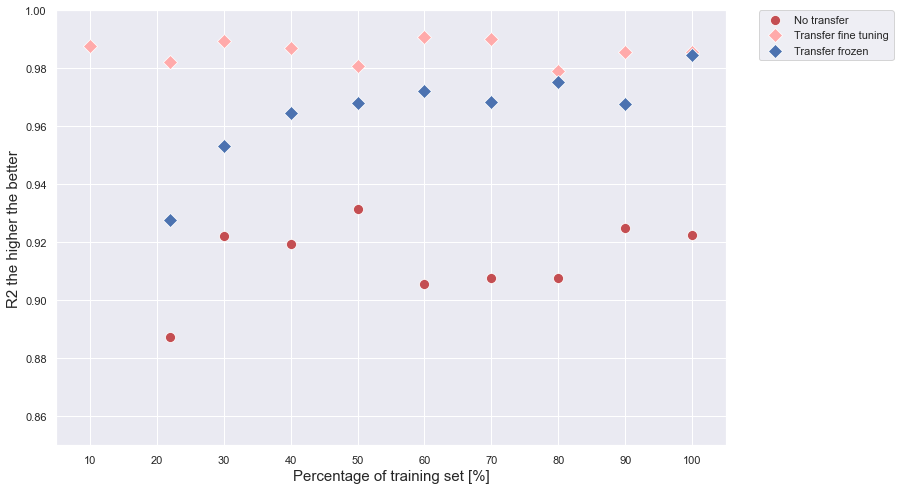

In [36]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
msize = 100
sns.set(rc={'figure.figsize':(12,8),'font.size': 16})
plt.xlim(5, 105)
plt.ylim(0.85, 1)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_without_transfer_result, label='No transfer', marker='o', color = 'r', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_frozen_result, label='Transfer fine tuning', marker = 'D', color = '#ffaaaa', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_fine_tuning_result, label='Transfer frozen', marker ='D', color = 'b', s=msize)
plt.xlabel('Percentage of training set [%]', fontsize=15)
plt.ylabel('R2 the higher the better', fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(10, 110, 10))
plt.show()